# NFL Game Penalties Prediction Model

## Introduction
This notebook outlines the process of building a neural network using TensorFlow and Keras to predict various NFL game penalties based on team, coaching, and game context data. The model aims to predict multiple penalty types using regression, while treating all input features, including the year, as categorical variables.

## Loading Data

In [178]:
import pandas as pd

# Load the dataset
file_path = '../data/processed/team_performances.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['game_id', 'pts', 'first_downs', 'net_pass_yards', 'total_yards', 'turnovers', 'time_of_possession', 'rush_attempts', 'rush_yards', 'rush_tds', 'passes_completed', 'passes_attempted', 'pass_yards',
             'pass_tds', 'interceptions', 'times_sacked', 'sack_yards_lost', 'fumbles', 'fumbles_lost', 'third_down_attempts', 'third_down_conversions', 'fourth_down_attempts', 'fourth_down_conversions'])

# Print number of target columns
print(data.shape[1] - 9)
data.head()

52


,team_id,opp_team_id,coach,opp_coach,home,postseason,year,week,ref_crew,Def_Unnecessary_Roughness,Off_Illegal_Formation,Off_Holding,Def_Pass_Interference,Def_Face_Mask,Def_Encroachment,Off_Delay_of_Game,Off_False_Start,Def_Illegal_Contact,Off_Offside,Off_Illegal_Shift,Def_Illegal_Use_of_Hands,Off_Unnecessary_Roughness,Def_Offside,Off_Ineligible_Downfield_Pass,Off_Personal_Foul,Off_Pass_Interference,Def_Unsportsmanlike_Conduct,Off_Unsportsmanlike_Conduct,Def_Roughing_the_Passer,Def_Personal_Foul,Def_Holding,Def_Neutral_Zone_Infraction,Off_Intentional_Grounding,Def_Delay_of_Game,Off_Illegal_Block_Above_the_Waist,Off_Illegal_Motion,Def_Taunting,Off_Illegal_Substitution,Off_Illegal_Forward_Pass,Off_Tripping,Off_Taunting,Off_Illegal_Touch_Pass,Def_12_On-field,Off_Illegal_Use_of_Hands,Off_Chop_Block,Def_Disqualification,Def_Illegal_Block_Above_the_Waist,Off_Face_Mask,Def_Horse_Collar_Tackle,Off_Clipping,Off_Illegal_Crackback,Off_Illegal_Blindside_Block,Off_12_On-field,Off_Disqualification,Def_Too_Many_Men_on_Field,Def_Lowering_the_Head_to_Initiate_Contact,Off_Too_Many_Men_on_Field,total_off_pen,total_def_pen,total_off_pen_yards,total_def_pen_yards
0,PIT,TEN,Mike Tomlin,Jeff Fisher,Yes,No,2009,1,Bill Leavy,1,1,2,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,30,30
1,TEN,PIT,Jeff Fisher,Mike Tomlin,No,No,2009,1,Bill Leavy,0,3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,13,5
2,ATL,MIA,Mike Smith,Tony Sparano,Yes,No,2009,1,Walt Coleman,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,25,10
3,MIA,ATL,Tony Sparano,Mike Smith,No,No,2009,1,Walt Coleman,0,0,2,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,20,7
4,BAL,KC,John Harbaugh,Todd Haley,Yes,No,2009,1,Gene Steratore,0,1,3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,29,18


## Preprocessing Data
Here we encode all input features as categorical using one-hot encoding and prepare the dataset for the neural network.

In [179]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

penalty_columns = data.columns[9:].tolist()  

# Function to calculate 3-game rolling averages
def calculate_rolling_averages(data, window_size, penalty_columns):
    for col in penalty_columns:
        # Use transform to ensure the index aligns with the original DataFrame
        data[f'rolling_avg_{col}'] = data.groupby(['team_id', 'year'])[col].transform(
            lambda x: x.shift(1).rolling(window=window_size, min_periods=1).mean())
    return data

# Apply the rolling averages with a window size of 3
data = calculate_rolling_averages(data, 3, penalty_columns)

# Extracting year and converting to categorical
data['year'] = pd.Categorical(data['year'])

# Handling categorical variables with one-hot encoding
categorical_cols = ['ref_crew', 'team_id', 'opp_team_id', 'coach', 'opp_coach', 'home', 'postseason', 'year', 'week']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Scaling the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data.drop(penalty_columns, axis=1))
y_scaled = scaler.fit_transform(data[penalty_columns])

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

data.head()

,Def_Unnecessary_Roughness,Off_Illegal_Formation,Off_Holding,Def_Pass_Interference,Def_Face_Mask,Def_Encroachment,Off_Delay_of_Game,Off_False_Start,Def_Illegal_Contact,Off_Offside,Off_Illegal_Shift,Def_Illegal_Use_of_Hands,Off_Unnecessary_Roughness,Def_Offside,Off_Ineligible_Downfield_Pass,Off_Personal_Foul,Off_Pass_Interference,Def_Unsportsmanlike_Conduct,Off_Unsportsmanlike_Conduct,Def_Roughing_the_Passer,Def_Personal_Foul,Def_Holding,Def_Neutral_Zone_Infraction,Off_Intentional_Grounding,Def_Delay_of_Game,Off_Illegal_Block_Above_the_Waist,Off_Illegal_Motion,Def_Taunting,Off_Illegal_Substitution,Off_Illegal_Forward_Pass,Off_Tripping,Off_Taunting,Off_Illegal_Touch_Pass,Def_12_On-field,Off_Illegal_Use_of_Hands,Off_Chop_Block,Def_Disqualification,Def_Illegal_Block_Above_the_Waist,Off_Face_Mask,Def_Horse_Collar_Tackle,...,opp_coach_Vic Fangio,opp_coach_Wade Phillips,opp_coach_Zac Taylor,home_Yes,postseason_Yes,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22
0,1,1,2,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0,3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,0,0,2,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,0,1,3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Neural Network Design

In [180]:
import tensorflow as tf
import keras
from keras_tuner import Hyperband

# Hyperparameter tuning setup
def build_model(hp):
    model = keras.models.Sequential([
        keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),
                           activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),
                           activation='relu'),
        keras.layers.Dense(y_train.shape[1], activation='linear')
    ])
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
    return model

tuner = Hyperband(build_model, objective='val_loss', max_epochs=10,
                  directory='my_dir', project_name='nfl_penalties_tuning')

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Final model training
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.1, verbose=1)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

Trial 30 Complete [00h 00m 04s]
val_loss: 0.007042383775115013

Best val_loss So Far: 0.007033944595605135
Total elapsed time: 00h 01m 13s
Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - mae: 0.0369 - val_loss: 0.0082 - val_mae: 0.0400
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mae: 0.0392 - val_loss: 0.0074 - val_mae: 0.0407
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.0070 - mae: 0.0399 - val_loss: 0.0073 - val_mae: 0.0404
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - mae: 0.0394 - val_loss: 0.0073 - val_mae: 0.0403
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.0070 - mae: 0.0397 - val_loss: 0.0073 - val_mae: 0.0402
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.0067 - mae: 0.0392 - val_loss: 0.0073 - val_mae: 0.0407
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - mae: 0.0395 - val_loss: 0.0073 - val_mae: 0.0404
Epoch 8/50
183/183 ━━━━━━━━━━

## Evaluating the Neural Network

In [181]:
from sklearn.metrics import mean_squared_error

# Predictions
y_pred = model.predict(X_test)

# Rescale predictions back to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate MSE for each target
mse_scores = mean_squared_error(y_test_rescaled, y_pred_rescaled, multioutput='raw_values')

# Overall MSE
overall_mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)

print("Overall Mean Squared Error (MSE):", overall_mse)
print("\nMSE by target variable:", mse_scores)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
Overall Mean Squared Error (MSE): 13.828682173577132

MSE by target variable: [3.06404785e-01 1.54769562e-01 1.40343881e+00 6.72986125e-01
 1.59582863e-01 9.93430820e-02 2.84529140e-01 1.34937431e+00
 1.89502954e-01 2.27015279e-02 1.08336715e-01 1.72806056e-01
 7.87548344e-02 6.19553354e-01 1.08468075e-01 1.70764975e-02
 2.07991815e-01 5.36605898e-02 4.27351234e-02 2.18356655e-01
 3.73848463e-02 6.13097650e-01 3.25595356e-01 1.16361105e-01
 1.16119989e-02 7.28662419e-02 4.07103724e-02 1.87926220e-02
 1.52221724e-02 2.18878903e-02 1.83121061e-02 2.12619280e-02
 1.93893529e-02 3.63604884e-02 7.95615541e-02 2.35344809e-02
 1.40670125e-02 1.40227693e-02 4.64012000e-02 3.30270834e-02
 7.34695591e-03 4.29824358e-03 1.47013578e-02 1.40467882e-02
 5.53410438e-03 4.22390464e-02 1.15770676e-02 7.96908625e-03
 5.17405976e+00 4.39515777e+00 2.71576025e+02 4.29988676e+02]


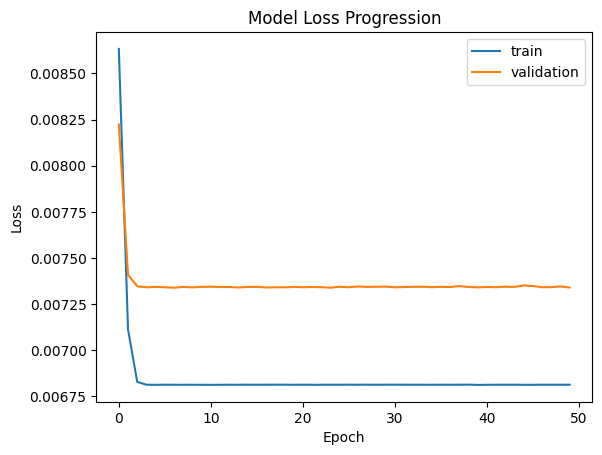

In [182]:
# Plotting training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()